## Harjoitustyö



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
!pip install scrapy

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached Scrapy-2.5.0-py2.py3-none-any.whl (254 kB)
Processing /root/.cache/pip/wheels/dc/d0/bf/0cc715c01fce0bace63b46283acf5cc630d5e5dbb4602c54e5/PyDispatcher-2.0.5-py3-none-any.whl
  Using cached zope.interface-5.4.0-cp37-cp37m-manylinux2010_x86_64.whl (251 kB)
Processing /root/.cache/pip/wheels/ca/44/01/3592ccfbcfaee4ab297c4097e6e9dbe1c7697e3531a39877ab/Protego-0.1.16-py3-none-any.whl
  Using cached w3lib-1.22.0-py2.py3-none-any.whl (20 kB)
  Using cached service_identity-18.1.0-py2.py3-none-any.whl (11 kB)
  Using cached itemadapter-0.2.0-py3-none-any.whl (9.3 kB)
  Using cac

In [22]:
!scrapy genspider etuovi_scraper etuovi.com

Created spider 'etuovi_scraper' using template 'basic' 


In [23]:
## lopullinen raapija

import scrapy
# raapija, joka kerää etuovi.com:sta ilmoituksien tiedoista
# asuntotyypin, osoitteen, hinnan, valmistuvuoden ja pinta-alan.
# (Kyseessä Tampereen omakotitalot)
class EtuoviScraperSpider(scrapy.Spider):
    name = 'etuovi_scraper'
    allowed_domains = ['etuovi.com']
    # assing a page url below
    start_urls = \
    ['https://www.etuovi.com/myytavat-asunnot?haku=M1644983732&sivu=0']

  # Funkito parse(self, response) käy läpi aloitusosoitteesta eteenpäin
  # sivuja, joilta dataa kerätään. Parse kutsuu parse_page-funktiota, jossa
  # on määritelty varsinainen kerättävä tieto.
  # max 5 sivua tässä esimerkissä
    def parse(self, response):
        for i in range(1, 21):
            url=response.request.url[:-1]+str(i)
            yield scrapy.Request(url, callback=self.parse_page)
        
    
    def parse_page(self, response):
        description_texts = response.css(\
          '[class="flexboxgrid__col-xs-12__1I1LS"] *::text').extract()
        size_text = response.css(\
          '[class="flexboxgrid__col-xs__26GXk flexboxgrid__col-md-4__2DYW-"] > span::text').extract()
        year_text = response.css(\
          '[class="flexboxgrid__col-xs-3__3Kf8r flexboxgrid__col-md-4__2DYW-"] > span::text'\
          ).extract()
        price_text = response.css(\
          '[class="flexboxgrid__col-xs-4__p2Lev flexboxgrid__col-md-4__2DYW-"] > span::text'\
          ).extract()

        for i in range(len(price_text)):
            yield {
                'house_type' : description_texts[2*i],
                'address': description_texts[2*i+1],
                'price': price_text[i],
                'year': year_text[i],
                'size': size_text[i]
            }

In [24]:
!scrapy runspider etuovi_scraper.py -o out.json

2021-04-23 15:18:27 [scrapy.utils.log] INFO: Scrapy 2.5.0 started (bot: scrapybot)
2021-04-23 15:18:27 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 21.2.0, Python 3.7.10 (default, Feb 26 2021, 18:47:35) - [GCC 7.3.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1k  25 Mar 2021), cryptography 3.4.7, Platform Linux-4.14.225-169.362.amzn2.x86_64-x86_64-with-debian-10.6
2021-04-23 15:18:27 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2021-04-23 15:18:27 [scrapy.crawler] INFO: Overridden settings:
{'SPIDER_LOADER_WARN_ONLY': True}
2021-04-23 15:18:27 [scrapy.extensions.telnet] INFO: Telnet Password: c610491975b07e21
2021-04-23 15:18:27 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
202

In [29]:
!git commit -m "data collection modified, data cleaning and visualization added"

[master 78d89c4] data collection modified, data cleaning and visualization added
 1 file changed, 2072 insertions(+), 135 deletions(-)


In [28]:
!git add 'joda_ht.ipynb'

In [2]:
!git config --global user.email "sara.paukkeri@hotmail.com"

## Datan siivoaminen ja piirteiden  muokkaus

In [30]:
import json

In [31]:
# read out.json file to d
d = open('out.json')
data = json.load(d)
d.close()
data[0:1]

[{'house_type': 'Omakotitalo | 4 h, k, ph, s, wc, at',
  'address': 'Unikeonkatu 6, Yli-Maaria, Turku',
  'price': '115\xa0000\xa0€',
  'year': '1968',
  'size': '99,5 / 124 m²'}]

In [81]:
# convert array to dataframe
df = pd.DataFrame(data)
df.head()

,house_type,address,price,year,size
0,"Omakotitalo | 4 h, k, ph, s, wc, at","Unikeonkatu 6, Yli-Maaria, Turku",115 000 €,1968,"99,5 / 124 m²"
1,Omakotitalo | 3h + k + 2wc + ph + s,"Lähteeläntie 11, Jyskä, Jyväskylä",135 000 €,1950,-
2,"Omakotitalo | 3mh, oh, avok, kh, 2wc, kph, s, ...","Kaistisenkatu 23, Piispanristi, Turku",398 000 €,2007,181 / 222 m²
3,"Omakotitalo | 7 mh, oh, k, rt, askarteluh, pkh...","Koppalankaari 60, Palokka/Terttumäki, Jyväskylä",385 000 €,1948,200 / 267 m²
4,"Omakotitalo | 5h, k, kph, s, AT","Ukkoherrankuja 3, Yli-Ii, Oulu",395 000 €,1989,120 / 180 m²


In [82]:
# split column size to size and living_space and remove "m2" and spaces
# add rows with empty values(="-") to remove
remove=[]

living_space=[]
for i in range(0, df['size'].size):
  
    if "/" in df['size'][i]: 
        sizes = df['size'][i].split("/")
        df['size'][i] = sizes[1].replace(" ", "").replace("m\u00b2","").replace(",",".")
        living_space.append(sizes[0].replace(" ", "").replace(",","."))
    elif df['size'][i] != "-": #  only one size available
        df['size'][i] = df['size'][i].replace(" ", "").replace("m\u00b2","").replace(",",".")
        living_space.append(df['size'][i])
    else: # size is "-" or
        living_space.append(0)
        remove.append(i)
        df['size'][i]=0
  
df['living_space']=living_space

df['size'] = df['size'].astype(float)
df.living_space = df.living_space.astype(float)

In [83]:
# remove € from price and set datatype to int
for i in range(0, df.price.size): #=0; i < df.price.length; i++):
    if (df.price[i]=="-") and (i not in remove):
        remove.append(i)
    else: 
        df.price[i] = df.price[i].replace("\xa0", "").replace('€',"")

df.price = df.price.astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
df.head()

,house_type,address,price,year,size,living_space
0,"Omakotitalo | 4 h, k, ph, s, wc, at","Unikeonkatu 6, Yli-Maaria, Turku",115000,1968,124.0,99.5
1,Omakotitalo | 3h + k + 2wc + ph + s,"Lähteeläntie 11, Jyskä, Jyväskylä",135000,1950,0.0,0.0
2,"Omakotitalo | 3mh, oh, avok, kh, 2wc, kph, s, ...","Kaistisenkatu 23, Piispanristi, Turku",398000,2007,222.0,181.0
3,"Omakotitalo | 7 mh, oh, k, rt, askarteluh, pkh...","Koppalankaari 60, Palokka/Terttumäki, Jyväskylä",385000,1948,267.0,200.0
4,"Omakotitalo | 5h, k, kph, s, AT","Ukkoherrankuja 3, Yli-Ii, Oulu",395000,1989,180.0,120.0


In [85]:
# Split address to address, region, area
area=[]
city=[]

for i in range(0, df['address'].size):
    add = df['address'][i].split(", ")
    df['address'][i] = add[0]
    if len(add) < 3:
        add2 = add[1].split(" ")
        if len(add2) < 2:
            city.append(add2[0])
            area.append(add2[0])
        else:
            city.append(add2[1])
            area.append(add2[0])
    else:
        area.append(add[1])
        city.append(add[2])
  
df['area']=area
df['city'] = city

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [86]:
rooms=[]

for i in range(0, df['house_type'].size):
    house = df['house_type'][i].split(" | ")
    if len(house) < 2: #only another information available
        df['house_type'][i] = house[0]
        rooms.append(house[0])
    else:
        df['house_type'][i] = house[0]
        rooms.append(house[1])
  
df['rooms']=rooms

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
for i in range(0, df.year.size):
    if df.year[i]=="-" and i not in remove:
        remove.append(i)

df = df.drop(remove)

df['year'] = df['year'].astype(int)

In [88]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms
0,Omakotitalo,Unikeonkatu 6,115000,1968,124.0,99.5,Yli-Maaria,Turku,"4 h, k, ph, s, wc, at"
2,Omakotitalo,Kaistisenkatu 23,398000,2007,222.0,181.0,Piispanristi,Turku,"3mh, oh, avok, kh, 2wc, kph, s, khh, 4vh"
3,Omakotitalo,Koppalankaari 60,385000,1948,267.0,200.0,Palokka/Terttumäki,Jyväskylä,"7 mh, oh, k, rt, askarteluh, pkh / khh, ph, s,..."
4,Omakotitalo,Ukkoherrankuja 3,395000,1989,180.0,120.0,Yli-Ii,Oulu,"5h, k, kph, s, AT"
5,Omakotitalo,Seelannintie 26,129000,1993,200.0,143.0,Herukka,Oulu,Erilliset liike- / toimitilat + 5h + tupak + k...


Muokataan osoite koordinaateiksi

In [57]:
!pip install geopy

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 112 kB 5.8 MB/s eta 0:00:01


In [89]:
# edit the address to a format suitable for the coordinate change
df['geo_address'] = df["address"]+ ", " + df["city"] + ", Finland"

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "joda ht")

In [90]:
df["loc"] = df["geo_address"].apply(geolocator.geocode)
# select koordinates from loc
df["point"] = df["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
#split coordinates to latitude, longitude and altitude
df[['lat', 'lon', 'altitude']] = pd.DataFrame(df['point'].to_list(), index=df.index)

In [91]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms,geo_address,loc,point,lat,lon,altitude
0,Omakotitalo,Unikeonkatu 6,115000,1968,124.0,99.5,Yli-Maaria,Turku,"4 h, k, ph, s, wc, at","Unikeonkatu 6, Turku, Finland","(6, Unikeonkatu, Yli-Maaria, Maaria-Paattinen,...","(60.5508547, 22.31609524144914, 0.0)",60.550855,22.316095,0.0
2,Omakotitalo,Kaistisenkatu 23,398000,2007,222.0,181.0,Piispanristi,Turku,"3mh, oh, avok, kh, 2wc, kph, s, khh, 4vh","Kaistisenkatu 23, Turku, Finland","(23, Kaistisenkatu, Kairiskulma, Piispanristi,...","(60.41573245, 22.32104154875271, 0.0)",60.415732,22.321042,0.0
3,Omakotitalo,Koppalankaari 60,385000,1948,267.0,200.0,Palokka/Terttumäki,Jyväskylä,"7 mh, oh, k, rt, askarteluh, pkh / khh, ph, s,...","Koppalankaari 60, Jyväskylä, Finland","(60, Koppalankaari, Terttumäki, Haukkamäki, Jy...","(62.297308349999994, 25.695705936147327, 0.0)",62.297308,25.695706,0.0
4,Omakotitalo,Ukkoherrankuja 3,395000,1989,180.0,120.0,Yli-Ii,Oulu,"5h, k, kph, s, AT","Ukkoherrankuja 3, Oulu, Finland","(Ukkoherrankuja, Yli-Ii, Oulu, Oulun seutukunt...","(65.3685837, 25.8408559, 0.0)",65.368584,25.840856,0.0
5,Omakotitalo,Seelannintie 26,129000,1993,200.0,143.0,Herukka,Oulu,Erilliset liike- / toimitilat + 5h + tupak + k...,"Seelannintie 26, Oulu, Finland","(Seelannintie, Herukka, Oulu, Oulun seutukunta...","(65.0988671, 25.416036, 0.0)",65.098867,25.416036,0.0


In [92]:
df['loc'][0]

Location(6, Unikeonkatu, Yli-Maaria, Maaria-Paattinen, Turku, Turun seutukunta, Varsinais-Suomi, Lounais-Suomen aluehallintovirasto, Manner-Suomi, 20400, Suomi / Finland, (60.5508547, 22.31609524144914, 0.0))

### Datan kuvaileminen

Text(0.5, 1.0, 'Living Space')

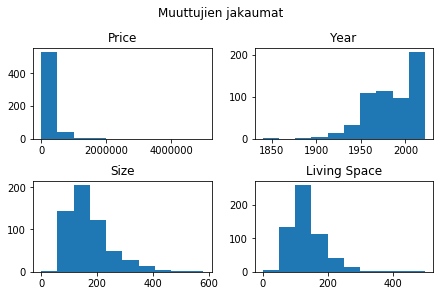

In [93]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)
fig.suptitle('Muuttujien jakaumat')

f_ax1 = fig.add_subplot(gs[0, 0])
f_ax1.hist(df['price'])
f_ax1.set_title('Price')
f_ax2 = fig.add_subplot(gs[0, 1])
f_ax2.hist(df['year'])
f_ax2.set_title('Year')
f_ax3 = fig.add_subplot(gs[1, 0])
f_ax3.hist(df['size'])
f_ax3.set_title('Size')
f_ax4 = fig.add_subplot(gs[1, 1])
f_ax4.hist(df['living_space'])
f_ax4.set_title('Living Space')

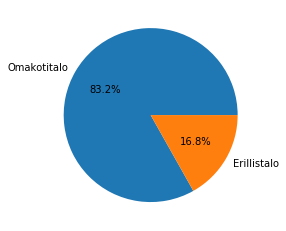

In [94]:
from collections import Counter

#type of houses in data
value = Counter(df['house_type']).values()
label = Counter(df['house_type']).keys()

plt.pie(value, labels = label, autopct='%1.1f%%')
plt.show()

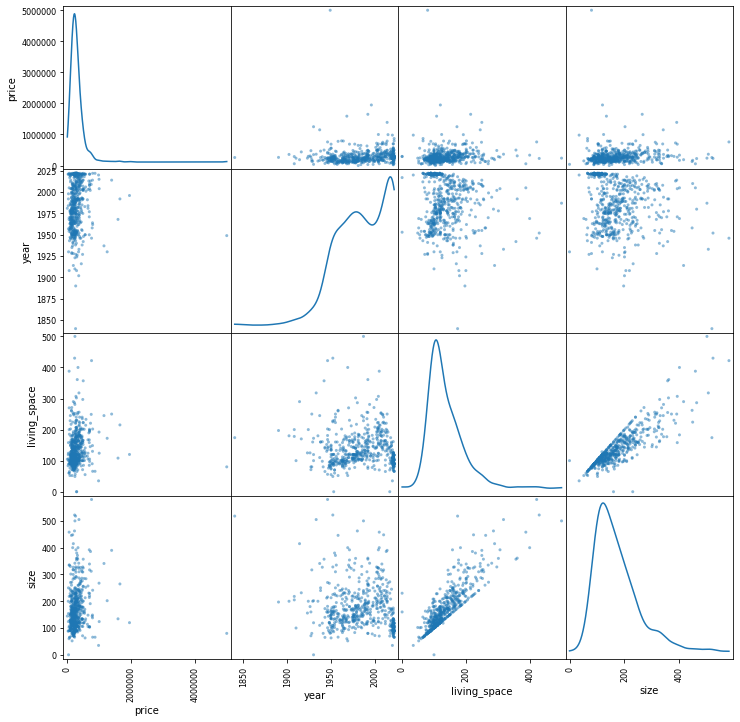

In [95]:
from pandas.plotting import scatter_matrix

# plot a scatter matrix to detect dependencies
df_int = df.loc[:,['price', 'year', 'living_space', 'size']]

scatter_matrix(df_int, figsize=(12,12), diagonal="kde");

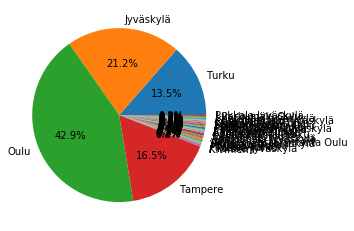

In [96]:
area_value = Counter(df['city']).values()
area_label = Counter(df['city']).keys()

#cities in data
plt.pie(area_value, labels = area_label, autopct='%1.1f%%')
plt.show()

In [97]:
area_label

dict_keys(['Turku', 'Jyväskylä', 'Oulu', 'Tampere', 'Kiviniemi', '/ Tölskä Jyväskylä', '/ Rusko Turku', 'Hiukkavaara', '/ Friskala Turku', 'Varjakka Oulu', 'Ikolanmäki Jyväskylä', 'Veneenveistäjänranta Oulu', 'oulu', 'Terttumäki Jyväskylä', 'Vaajakoski Jyväskylä', 'Keskusta Oulu', '/ Lauttaranta Turku', '/ Toijainen Turku', 'Aaltokangas Oulu', 'Papinsaari Turku', '/ Martinniemi Oulu', 'Pappilanvuori Jyväskylä', '/ Papinsaari Turku', 'Hiukkavaara Oulu', '/ Halosenniemi Oulu', 'Sankari Turku', 'Kaistarniemi Turku', 'Oulu Oulu', 'Friskala Turku', 'Kummunmäki Jyväskylä', '', '/ Kotimäki Jyväskylä', '/ Parkumäki Oulu', 'Pukkala Jyväskylä'])

In [67]:
!pip install folium

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 464 kB/s eta 0:00:011


In [98]:
import folium
from folium.plugins import MarkerCluster

#Define coordinates of where we want to center our map
center = [61.6027417, 23.8721711]

#Create the map
my_map = folium.Map(location = center, zoom_start = 5)

# Add addresses to the map
for index, row in df.iterrows():
  if row.point != None:
    text ="Price: " + str(row.price) + " €" + "\n Size: " + str(row['size']) + " m2 " + "Address: " + row.address
    folium.Marker([row.lat,row.lon], popup = text).add_to(my_map)

#Display the map
my_map

### Koneoppiminen

In [99]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer

import os

In [111]:
dfTampere = df.iloc[:,[0,2,3,4,7]]
dfTampere = dfTampere[ dfTampere['city'] == 'Tampere']
dfTampere.head()

,house_type,price,year,size,city
6,Omakotitalo,289000,1971,354.0,Tampere
7,Omakotitalo,365000,1933,505.0,Tampere
29,Omakotitalo,139000,1999,271.0,Tampere
34,Omakotitalo,248000,1992,194.8,Tampere
40,Omakotitalo,184000,1989,174.0,Tampere


In [121]:
df.shape[0]

576

In [136]:
#0=house_type, 1=address 2=price, 3=year, 4=size, 7=city
#12=lat, 12=lon

# data of Tampere for later use
dfTampere = df.iloc[:,[0,1,2,3,4,7,12,13]]
dfTampere = dfTampere[ dfTampere['city'] == 'Tampere']
#Validation data
dfValid = df.iloc[:,[0,2,3,4,7]]
dfValid = dfValid[ dfValid['city'] == 'Jyväskylä']
# Train and test data
dfTrain = df.iloc[:,[0,2,3,4,7]]
dfTrain = dfTrain[ dfTrain['city'] != ('Tampere' or 'Jyväksylä')]

In [122]:
print("dfTampere:", dfTampere.shape[0])
print("dfValid:", dfValid.shape[0])
print("dfTrain:", dfTrain.shape[0])


dfTampere: 95
dfValid: 122
dfTrain: 481


In [137]:
#independent value (house_type, year, size)
dfTest_x= dfTrain.iloc[0:80, [0,2,3]]
#dependent value (price)
dfTest_y= dfTrain.iloc[0:80, 1]

dfTrain_x = dfTrain.iloc[80:(dfTrain.shape[0]), [0,2,3]]
dfTrain_y = dfTrain.iloc[80:(dfTrain.shape[0]), 1]


In [139]:
print("dfTrain:", dfTrain.shape[0])
print("dfTest:", dfTest.shape[0])
dfTest_x.head()


dfTrain: 481
dfTest: 80


,house_type,year,size
0,Omakotitalo,1968,124.0
2,Omakotitalo,2007,222.0
3,Omakotitalo,1948,267.0
4,Omakotitalo,1989,180.0
5,Omakotitalo,1993,200.0


In [140]:
dfTest_y.head()

0    115000
2    398000
3    385000
4    395000
5    129000
Name: price, dtype: int64